In [ ]:
#Imports
import gym
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.optimizers import Adadelta
import random

In [ ]:
#Create Gym
from gym import wrappers
envCartPole = gym.make('CartPole-v1')
envCartPole.seed(50) #Set the seed to keep the environment consistent across runs

[50]

In [ ]:
tmp_array = []
for i in range(100):
    tmp_array.append(i)
    
#Add 10 to each element
for i in range(100):
    tmp_array[i] += 10
print(tmp_array)

[10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109]


In [ ]:
#vectorized
tmp_array = []
for i in range(100):
    tmp_array.append(i)
    
#Add 10 to each element
tmp_array = np.array(tmp_array) + 10
print(tmp_array)

[ 10  11  12  13  14  15  16  17  18  19  20  21  22  23  24  25  26  27
  28  29  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45
  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60  61  62  63
  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80  81
  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99
 100 101 102 103 104 105 106 107 108 109]


In [ ]:
#Global Variables
EPISODES = 500
TRAIN_END = 0

In [ ]:
#Hyperparameters
discount_rate = .95
learning_rate = .001
batch_size = 24

In [ ]:
class DeepQNetwork():
    #set the local parameters + use dequedeque(circular queue) for local memory 
    #keras model for neural network
    def __init__(self, states, actions, alpha, gamma, epsilon, epsilon_min, epsilon_decay):
        self.nS = states
        self.nA = actions
        self.memory = deque([], maxlen=2500)
        self.alpha = alpha
        self.gamma = gamma
        #Explore/Exploit
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.model = self.build_model()
        self.loss = []

    #build a neural network with 2 hidden layers and use Adam as optimizer
    def build_model(self):
        model = keras.Sequential() 
        #linear stack of layers https://keras.io/models/sequential/

        model.add(keras.layers.Dense(24, input_dim = self.nS, activation = 'relu')) #[Input] -> Layer 1
        #   Dense: Densely connected layer https://keras.io/layers/core/
        #   24: Number of neurons
        #   input_dim: Number of input variables
        #   activation: Rectified Linear Unit (relu) ranges >= 0
        
        model.add(keras.layers.Dense(24, activation='relu')) 
        #   2 hidden layers

        model.add(keras.layers.Dense(self.nA, activation='linear')) 
        #   output layer
        #   Size has to match the output (different actions)
        #   Linear activation on the last layer
        
        # model.compile(loss='mean_squared_error', #Loss function: Mean Squared Error
        #               optimizer=keras.optimizers.Adam(lr=self.alpha)) #Optimaizer: Adam

        model.compile(loss='mean_squared_error', #Loss function: Mean Squared Error
                      optimizer=keras.optimizers.Adam(lr=self.alpha)) #Optimaizer: Adam
        return model

    #used to generate action value 
    #random an epsilon greedy
    def action(self, state):
        if np.random.rand() <= self.epsilon:
            #Explore
            return random.randrange(self.nA) 
        
        action_vals = self.model.predict(state)
        #Exploit: Use the NN to predict the correct action from this state
        return np.argmax(action_vals[0])

    #generate action
    def test_action(self, state): #Exploit
        action_vals = self.model.predict(state)
        return np.argmax(action_vals[0])

    #data memory storage 
    def store(self, state, action, reward, nstate, done):
        #Store the experience in memory
        self.memory.append((state, action, reward, nstate, done))

    #use experience replay to train agent
    def experience_replay(self, batch_size):
        #Execute the experience replay
        minibatch = random.sample( self.memory, batch_size ) 
        #Randomly sample from memory

        #Convert to numpy for speed by vectorization
        x = []
        y = []
        np_array = np.array(minibatch)
        st = np.zeros((0,self.nS)) 
        #States
        
        nst = np.zeros( (0,self.nS) )
        #Next States
        
        #Creating the state and next state np arrays
        for i in range(len(np_array)): 
            st = np.append( st, np_array[i,0], axis=0)
            nst = np.append( nst, np_array[i,3], axis=0)

        st_predict = self.model.predict(st) #Here is the speedup! I can predict on the ENTIRE batch
        nst_predict = self.model.predict(nst)
        index = 0

        for state, action, reward, nstate, done in minibatch:
            x.append(state)
            #Predict from state
            nst_action_predict_model = nst_predict[index]
            if done == True: #Terminal: Just assign reward much like {* (not done) - QB[state][action]}
                target = reward
            else:   #Non terminal
                target = reward + self.gamma * np.amax(nst_action_predict_model)

            target_f = st_predict[index]
            target_f[action] = target
            y.append(target_f)
            index += 1

        #Reshape for Keras Fit
        x_reshape = np.array(x).reshape(batch_size,self.nS)
        y_reshape = np.array(y)
        epoch_count = 1 #Epochs is the number or iterations
        hist = self.model.fit(x_reshape, y_reshape, epochs=epoch_count, verbose=0)
        
        #Graph Losses
        for i in range(epoch_count):
            self.loss.append( hist.history['loss'][i] )
        
        #Decay Epsilon
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

In [ ]:
#Create the agent
nS = envCartPole.observation_space.shape[0] #This is only 4
nA = envCartPole.action_space.n #Actions
dqn = DeepQNetwork(nS, nA, learning_rate, discount_rate, 1, 0.001, 0.995 )

In [ ]:
#Training process
rewards = []
# Store the Explore/Exploit
epsilons = [] 

TEST_Episodes = 0

for e in range(EPISODES):
    state = envCartPole.reset()
    state = np.reshape(state, [1, nS]) # Resize to store in memory to pass to .predict
    tot_rewards = 0

    for time in range(210): #200 is when you "solve" the game. This can continue forever as far as I know
        action = dqn.action(state)
        nstate, reward, done, _ = envCartPole.step(action)
        nstate = np.reshape(nstate, [1, nS])
        tot_rewards += reward
        dqn.store(state, action, reward, nstate, done) # Resize to store in memory to pass to .predict
        state = nstate
        #done: CartPole fell. 
        #time == 209: CartPole stayed upright

        if done or time == 209:
            rewards.append(tot_rewards)
            epsilons.append(dqn.epsilon)
            print("episode: {}/{}, score: {}, e: {}".format(e, EPISODES, tot_rewards, dqn.epsilon))
            break
        #Experience Replay
        if len(dqn.memory) > batch_size:
            dqn.experience_replay(batch_size)

    #If our current NN passes we are done
    #I am going to use the last 5 runs
    if len(rewards) > 5 and np.average(rewards[-5:]) > 195:
        #Set the rest of the EPISODES for testing
        TEST_Episodes = EPISODES - e
        TRAIN_END = e
        break

episode: 0/500, score: 17.0, e: 1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:73: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


episode: 1/500, score: 23.0, e: 0.9275689688183278
episode: 2/500, score: 14.0, e: 0.8690529955452602
episode: 3/500, score: 38.0, e: 0.7219385759785162
episode: 4/500, score: 19.0, e: 0.6596532430440636
episode: 5/500, score: 18.0, e: 0.6057704364907278
episode: 6/500, score: 15.0, e: 0.5647174463480732
episode: 7/500, score: 12.0, e: 0.5344229416520513
episode: 8/500, score: 11.0, e: 0.5082950737585841
episode: 9/500, score: 17.0, e: 0.46912134373457726
episode: 10/500, score: 11.0, e: 0.446186062443672
episode: 11/500, score: 12.0, e: 0.4222502236424958
episode: 12/500, score: 10.0, e: 0.4036245882390106
episode: 13/500, score: 10.0, e: 0.3858205374665315
episode: 14/500, score: 10.0, e: 0.36880183088056995
episode: 15/500, score: 9.0, e: 0.3543053533848483
episode: 16/500, score: 9.0, e: 0.3403786882983606
episode: 17/500, score: 18.0, e: 0.3125753549412418
episode: 18/500, score: 10.0, e: 0.2987875242397482
episode: 19/500, score: 10.0, e: 0.285607880564032
episode: 20/500, score:

In [ ]:
#Testing process
for e_test in range(TEST_Episodes):
    state = envCartPole.reset()
    state = np.reshape(state, [1, nS])
    tot_rewards = 0
    for t_test in range(210):
        action = dqn.test_action(state)
        nstate, reward, done, _ = envCartPole.step(action)
       
        nstate = np.reshape( nstate, [1, nS])
        tot_rewards += reward
        #DON'T STORE ANYTHING DURING TESTING
        state = nstate
        #done: CartPole fell. 
        #t_test == 209: CartPole stayed upright
        if done or t_test == 209: 
            rewards.append(tot_rewards)
            epsilons.append(0) #We are doing full exploit
            print("episode: {}/{}, score: {}, e: {}"
                  .format(e_test, TEST_Episodes, tot_rewards, 0))
            break;

episode: 0/398, score: 175.0, e: 0
episode: 1/398, score: 171.0, e: 0
episode: 2/398, score: 210.0, e: 0
episode: 3/398, score: 210.0, e: 0
episode: 4/398, score: 210.0, e: 0
episode: 5/398, score: 210.0, e: 0
episode: 6/398, score: 210.0, e: 0
episode: 7/398, score: 169.0, e: 0
episode: 8/398, score: 210.0, e: 0
episode: 9/398, score: 210.0, e: 0
episode: 10/398, score: 165.0, e: 0
episode: 11/398, score: 189.0, e: 0
episode: 12/398, score: 159.0, e: 0
episode: 13/398, score: 187.0, e: 0
episode: 14/398, score: 210.0, e: 0
episode: 15/398, score: 185.0, e: 0
episode: 16/398, score: 210.0, e: 0
episode: 17/398, score: 169.0, e: 0
episode: 18/398, score: 210.0, e: 0
episode: 19/398, score: 147.0, e: 0
episode: 20/398, score: 210.0, e: 0
episode: 21/398, score: 210.0, e: 0
episode: 22/398, score: 166.0, e: 0
episode: 23/398, score: 210.0, e: 0
episode: 24/398, score: 210.0, e: 0
episode: 25/398, score: 196.0, e: 0
episode: 26/398, score: 165.0, e: 0
episode: 27/398, score: 210.0, e: 0
ep

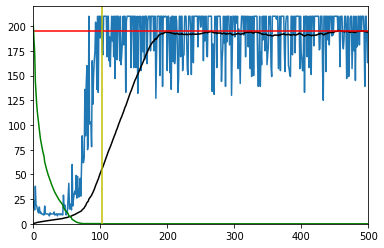

In [ ]:
#plot 
rolling_average = np.convolve(rewards, np.ones(100)/100)

plt.plot(rewards)
plt.plot(rolling_average, color='black')

plt.axhline(y=195, color='r', linestyle='-') #Solved Line
#Scale Epsilon (0.001 - 1.0) to match reward (0 - 200) range

eps_graph = [200*x for x in epsilons]

plt.plot(eps_graph, color='g', linestyle='-')
#Plot the line where TESTING begins
plt.axvline(x=TRAIN_END, color='y', linestyle='-')
plt.xlim( (0,EPISODES) )
plt.ylim( (0,220) )
plt.show()


envCartPole.close()